<a href="https://colab.research.google.com/github/wkt84/emt-python/blob/master/notebook/Python11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install pydicom
import pydicom

In [31]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [32]:
cd '/gdrive/My Drive/python/DICOMdata/'

/gdrive/My Drive/python/DICOMdata


In [0]:
# よく使うパッケージと表示の設定

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('axes', grid='False')

### matplotlib.pathの使い方

In [0]:
from matplotlib.path import Path
import matplotlib.patches as patches

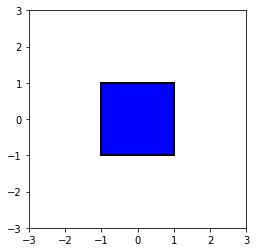

In [35]:
verts = [
    (1,1),
    (-1,1),
    (-1,-1),
    (1,-1),
    (1,1) # 最初に戻る
]

codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY
]

path = Path(verts, codes)

fig = plt.figure()
ax = fig.add_subplot(111)
patch = patches.PathPatch(path, fc='blue', lw=2)
ax.add_patch(patch)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')

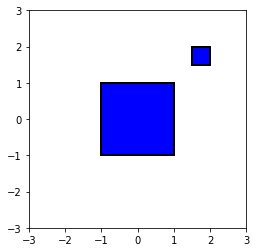

In [36]:
verts2 = [
    (1.5,1.5),
    (2,1.5),
    (2,2),
    (1.5,2),
    (1.5,1.5)
]

codes2 = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY
]

new_verts = verts + verts2
new_codes = codes + codes2

path = Path(new_verts, new_codes)

fig = plt.figure()
ax = fig.add_subplot(111)
patch = patches.PathPatch(path, fc='blue', lw=2)
ax.add_patch(patch)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')

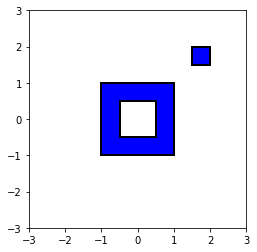

In [37]:
verts3 = [
    (0.5,0.5),
    (0.5,-0.5),
    (-0.5,-0.5),
    (-0.5,0.5),
    (0.5,0.5)
]

codes3 = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY
]

new_verts2 = new_verts + verts3
new_codes2 = new_codes + codes3

path = Path(new_verts2, new_codes2)

fig = plt.figure()
ax = fig.add_subplot(111)
patch = patches.PathPatch(path, fc='blue', lw=2)
ax.add_patch(patch)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')

In [0]:
rtss = pydicom.dcmread('RS.002445.dcm')

In [39]:
    structures = {}

    for roi in rtss.StructureSetROISequence:
        structures[roi.ROINumber] = roi.ROIName
        print('ROI number: ', roi.ROINumber, 'ROI name: ', roi.ROIName)

ROI number:  1 ROI name:  RT LENS
ROI number:  2 ROI name:  SPINAL_CORD
ROI number:  3 ROI name:  CORD+5MM
ROI number:  4 ROI name:  LT_PAROTID
ROI number:  5 ROI name:  MANDIBLE
ROI number:  7 ROI name:  RETROPHARYNGEAL
ROI number:  9 ROI name:  RT OPTIC NERVE
ROI number:  10 ROI name:  RT SMG
ROI number:  11 ROI name:  CTV56
ROI number:  12 ROI name:  BRAIN
ROI number:  13 ROI name:  LT LENS
ROI number:  14 ROI name:  BRAINSTEM
ROI number:  15 ROI name:  GTV70
ROI number:  16 ROI name:  LT OPTIC NERVE
ROI number:  17 ROI name:  CTV63
ROI number:  18 ROI name:  PTV70
ROI number:  19 ROI name:  PTV63
ROI number:  20 ROI name:  RT EYE
ROI number:  22 ROI name:  PTV56
ROI number:  23 ROI name:  CTV70
ROI number:  25 ROI name:  LT EYE
ROI number:  26 ROI name:  RT_PAROTID
ROI number:  29 ROI name:  LARYNX
ROI number:  30 ROI name:  BODY
ROI number:  31 ROI name:  LEFT LUNG
ROI number:  32 ROI name:  RT LUNG
ROI number:  36 ROI name:  LT COCHLEA
ROI number:  37 ROI name:  RT COCHLEA


In [0]:
contours = {}

# Structureごとにループする
for contour in rtss.ROIContourSequence:
    structure = structures[contour.ReferencedROINumber]  # 輪郭名を取得
    contours[structure] = {}  # 輪郭名をKeyとして空辞書を作成
    
    # まずは座標点を取得する
    points = {}
    for c in contour.ContourSequence:
        # 閉じた輪郭以外は無視する
        if c.ContourGeometricType != 'CLOSED_PLANAR':
            continue
        contour_data = c.ContourData
        x = [float(x) for x in contour_data[::3]]
        y = [float(y) for y in contour_data[1::3]]
        z = float(contour_data[2])
        xy = list(zip(x, y))  # x座標とy座標を1組のリストに
        xy.append(xy[0])  # 最後の輪郭座標に1点めの座標を足して輪郭が閉じるようにする
        
        # 同じz座標に複数の輪郭がある場合はリストとして格納
        if z not in points:
            points[z] = []  # 初めてのz座標のときは空リストを作成
        points[z].append(xy)  # リストに輪郭を追加
    # pointsというKeyにz座標に対する輪郭点を格納した辞書を追加
    contours[structure]['points'] = points
    
    # 表示用のPathを作成
    paths = {}
    for z, p in points.items():
        if len(p) > 1:  # 同じz座標に輪郭が2つ以上ある場合
            for i, c in enumerate(p):
                # Path生成用のcodeを作成
                codes = np.ones(len(c)) * Path.LINETO
                codes[0] = Path.MOVETO  # 輪郭点のはじめはMOVETO
                codes[-1] = Path.CLOSEPOLY  # 輪郭点の終わりはCLOSEPOLY
                if i==0:  # 最初の輪郭
                    all_paths = c
                    all_codes = codes
                else:  # 2つ目以降の輪郭を合体
                    all_paths = np.concatenate((all_paths, c))
                    all_codes = np.concatenate((all_codes, codes))
        else:  # 同じz座標に輪郭が1つの場合
            all_paths = p[0]
            all_codes = np.ones(len(p[0])) * Path.LINETO
            all_codes[0] = Path.MOVETO
            all_codes[-1] = Path.CLOSEPOLY

        path = Path(all_paths, all_codes)
        paths[z] = path
    # pathsというKeyにz座標に対するPathを格納した辞書を追加
    contours[structure]['paths'] = paths
    
    
    # 色の設定（必須タグではないので情報がないこともある）
    color = [
        float(contour.ROIDisplayColor[0]) / 255.,  # DICOM上はRGBが0-255で格納
        float(contour.ROIDisplayColor[1]) / 255.,  # matplotlibでは0-1で指定
        float(contour.ROIDisplayColor[2]) / 255.,  # 255で割って0-1に変換
        0.3                                        # 不透過度の設定
    ]
    contours[structure]['ec'] = color[0:3]  # 輪郭のEdgeは透過設定なし
    contours[structure]['fc'] = color       # 輪郭の内部は透過設定あり

## 輪郭だけで表示する

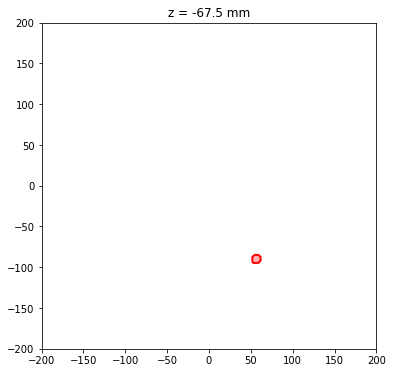

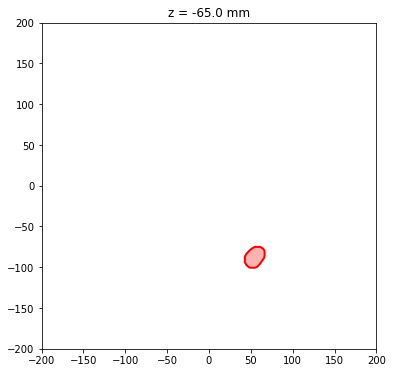

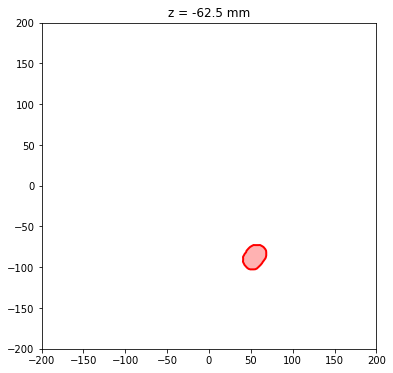

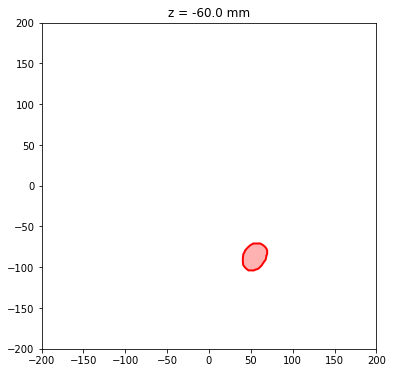

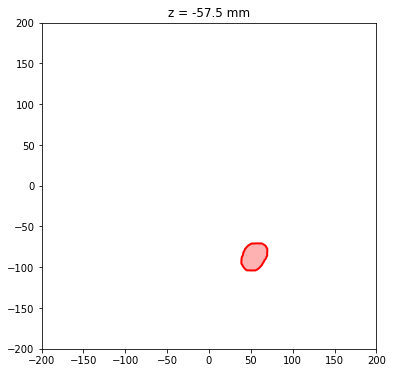

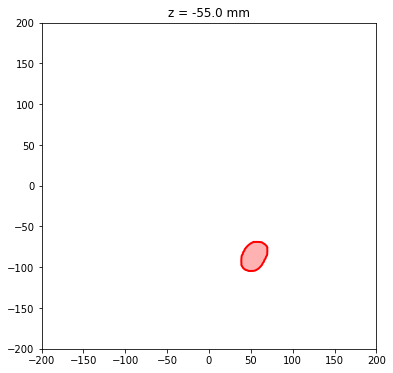

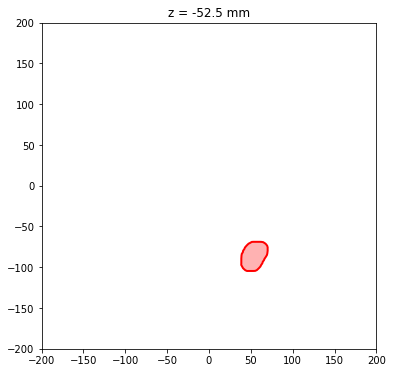

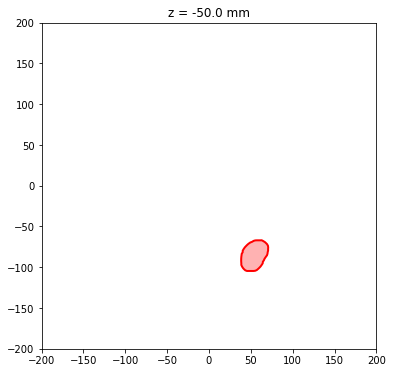

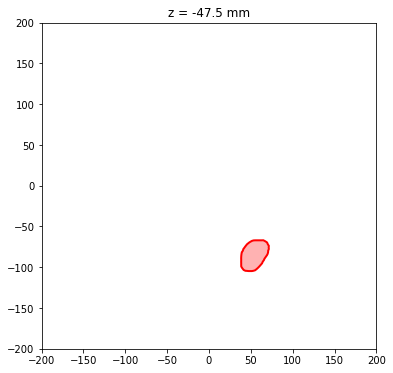

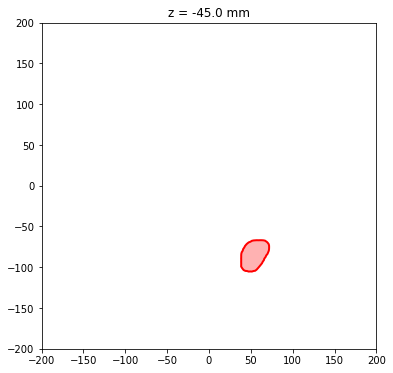

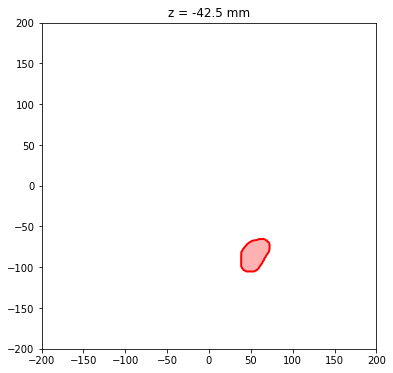

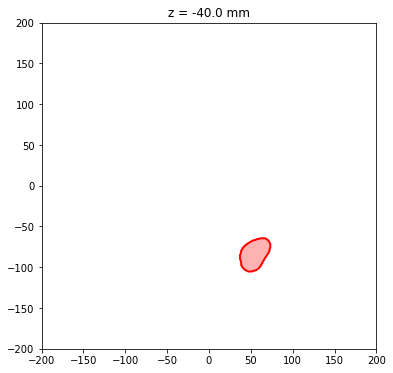

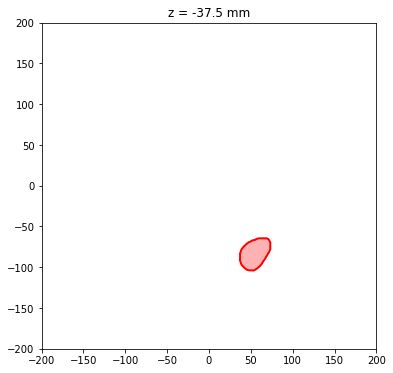

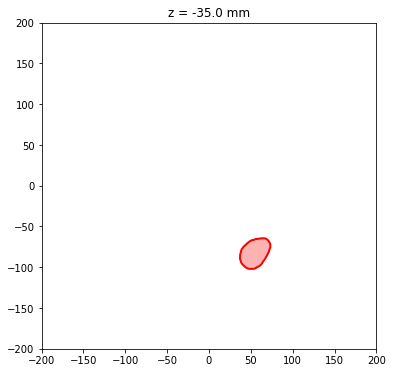

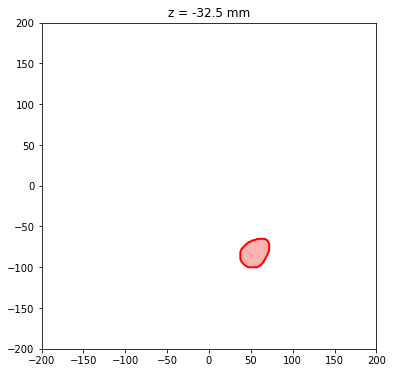

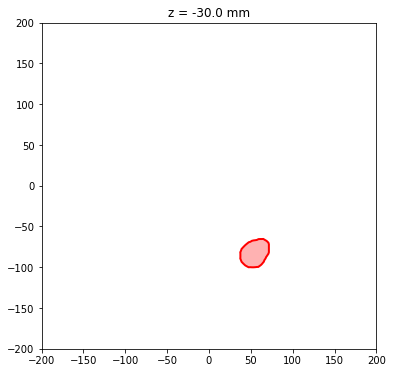

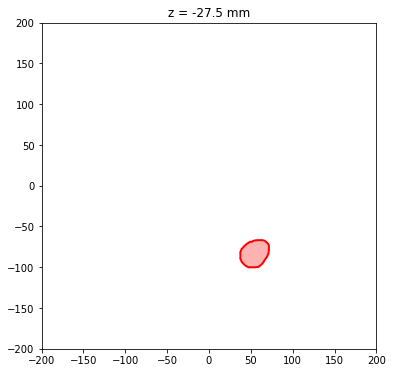

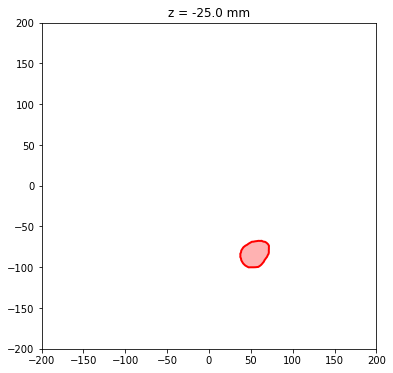

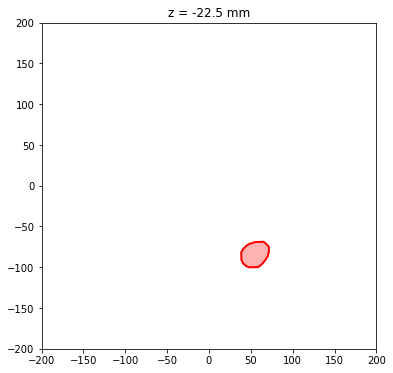

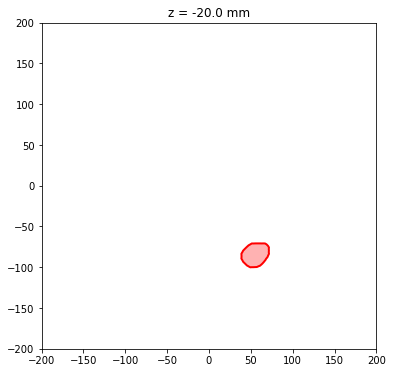

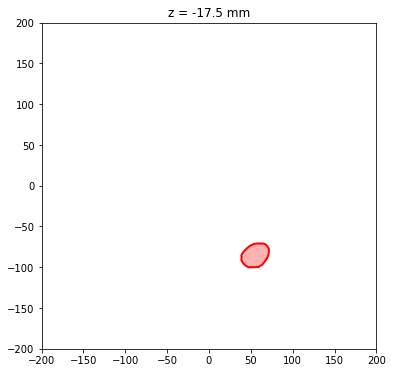

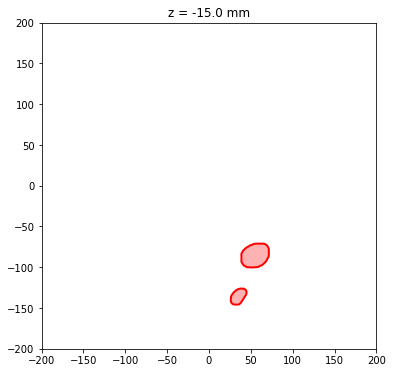

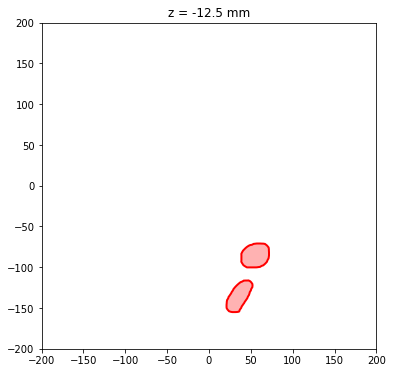

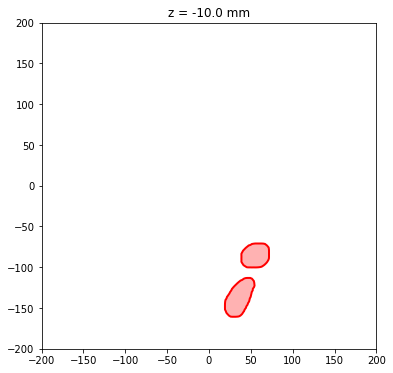

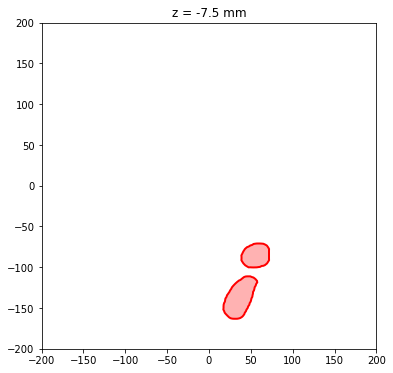

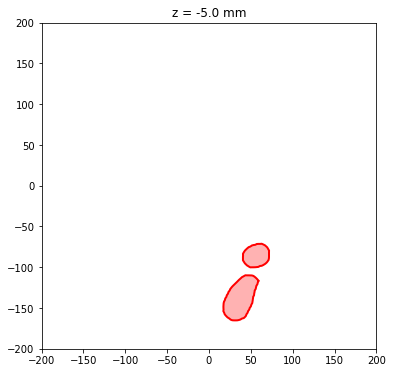

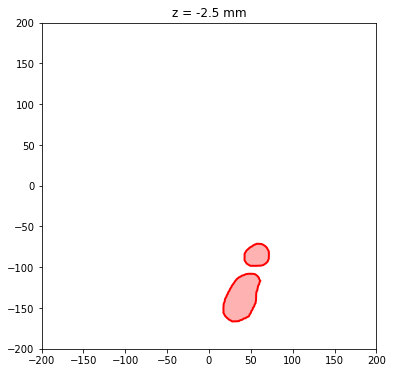

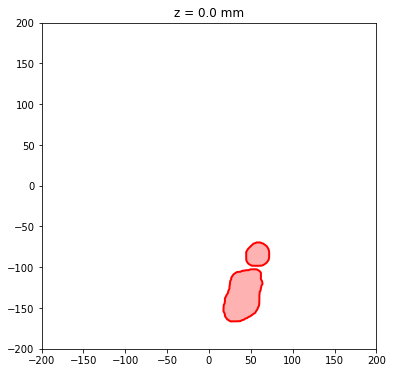

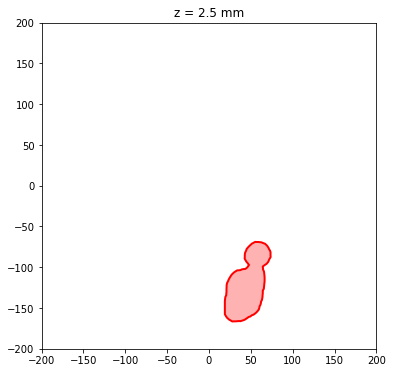

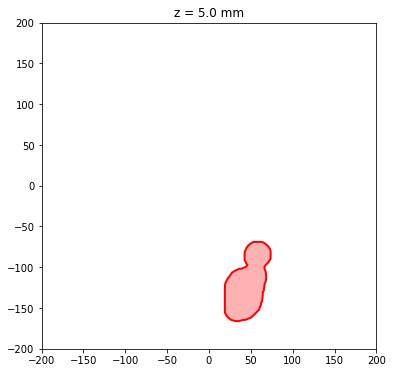

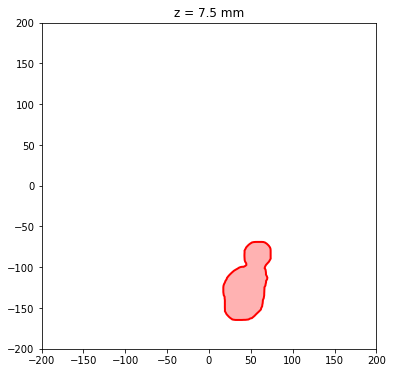

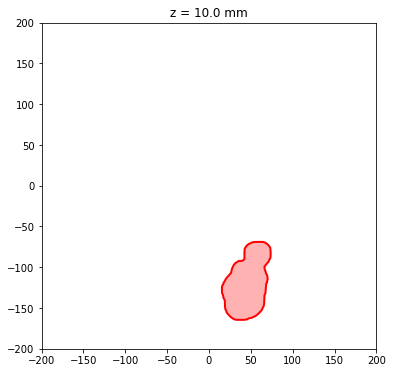

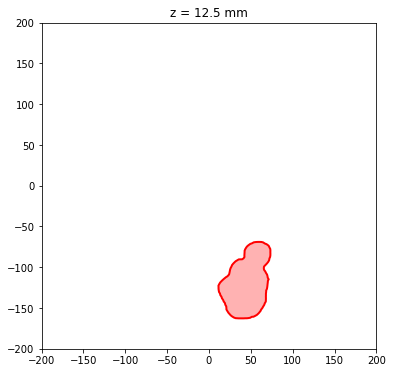

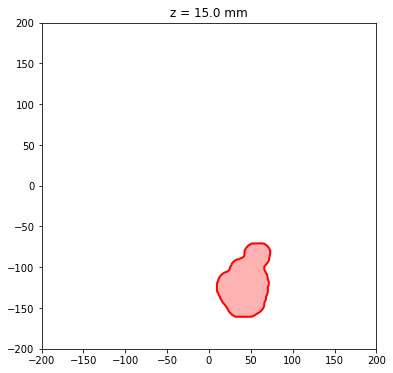

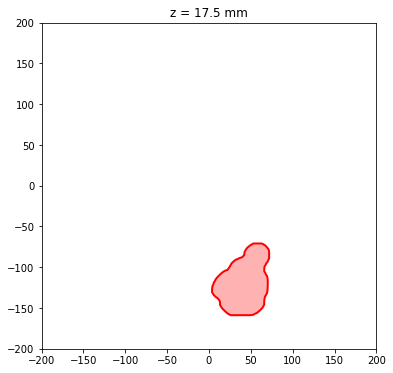

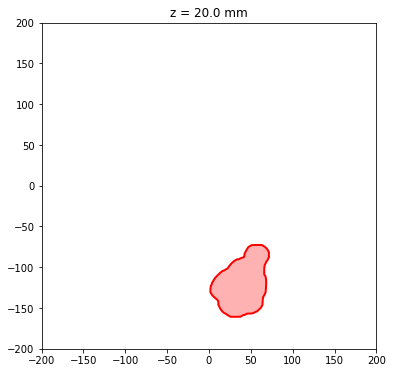

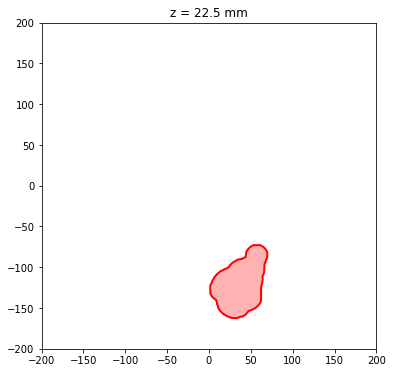

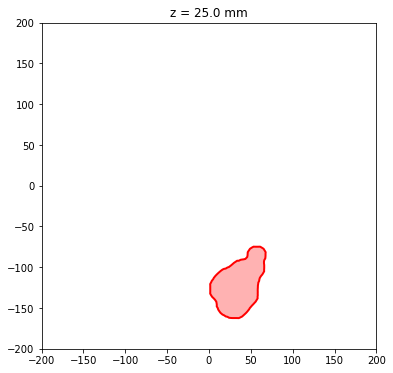

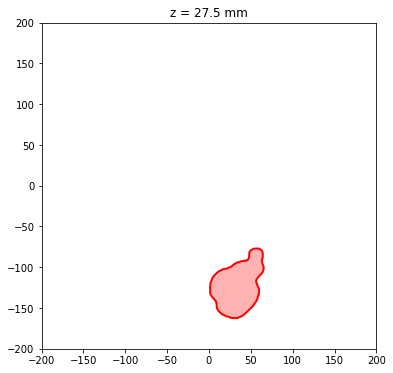

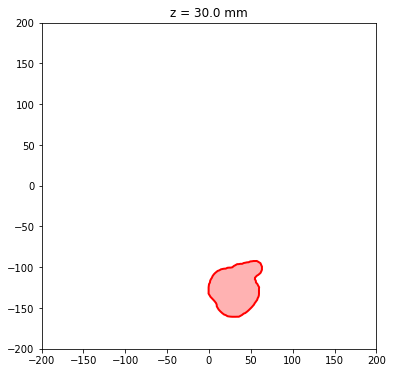

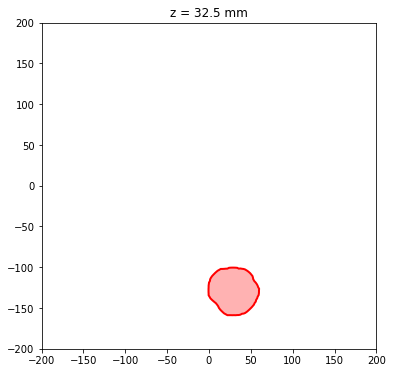

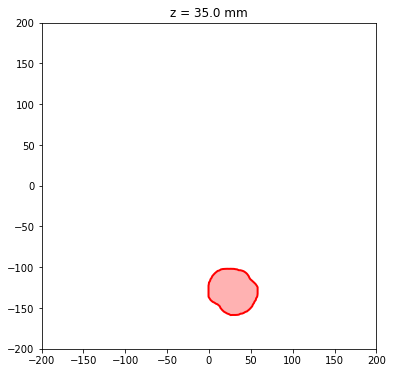

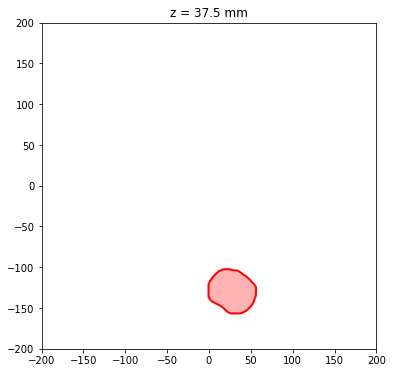

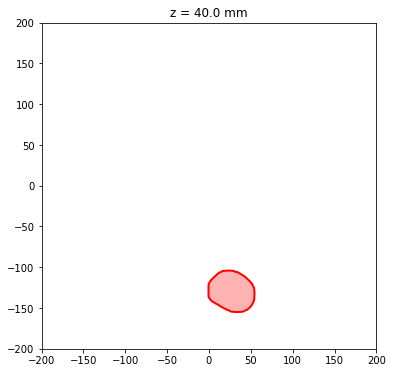

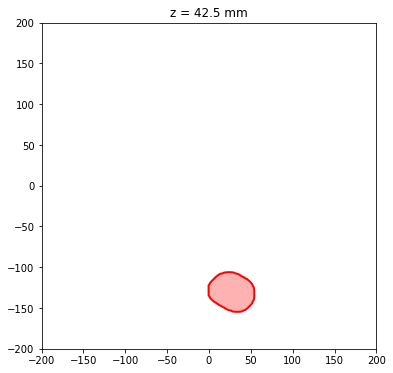

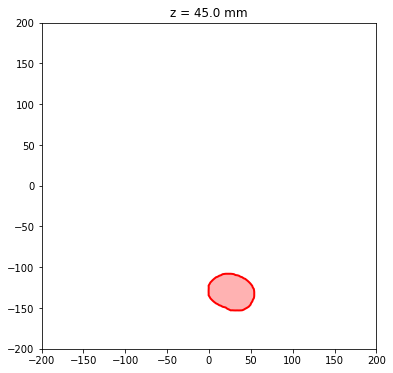

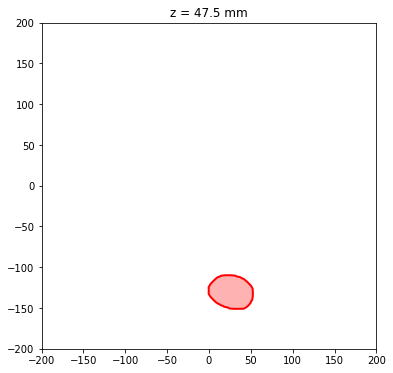

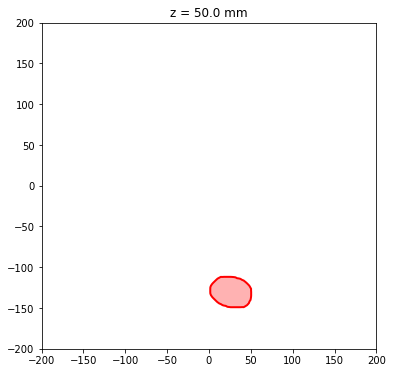

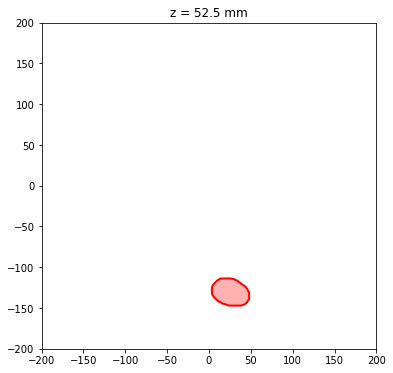

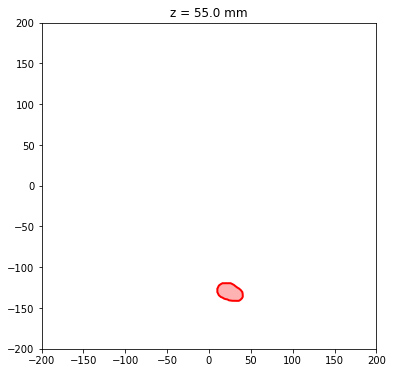

In [41]:
# 輪郭を指定
st = contours['PTV70']

for z, path in sorted(st['paths'].items(), key=lambda x: x[0]):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    patch = patches.PathPatch(path, ec=st['ec'], fc=st['fc'], lw=2)
    ax.add_patch(patch)
    ax.set_xlim(-200,200)
    ax.set_ylim(-200,200)
    ax.set_title('z = {0} mm'.format(z))
    plt.show()
    plt.close()

## CT画像といっしょに表示する

In [42]:
!pip install pydicom-tools
from pydicom_tools import CTImage
from matplotlib import animation
from IPython.display import HTML

In [0]:
ct = CTImage()
ct.load('./')  # CTの読み込み

In [44]:
# 輪郭の指定
structure_list = ['PTV70', 'CTV70', 'SPINAL_CORD']

# 座標の設定
extent = (ct.x_min, ct.x_max, ct.y_max, ct.y_min)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.close()

def update(frame):
    if frame != 0:
        ax.cla()
    ax.imshow(ct.volume[frame,:,:],
              cmap='gray', vmin=-300, vmax=500, extent=extent) # CTの表示
    for structure in structure_list:
        st = contours[structure]
        # 指定したz座標に輪郭がある場合のみ表示する
        if ct.z_array[frame] in st['paths']:
            patch = patches.PathPatch(st['paths'][ct.z_array[frame]],
                                      fill=True, ec=st['ec'], fc=st['fc'], lw=2)
            ax.add_patch(patch)
    
    ax.set_aspect('equal')
    ax.set_title('z = {0} mm'.format(ct.z_array[frame]))

anim = animation.FuncAnimation(fig, update, interval=30, frames=len(ct.z_array))
HTML(anim.to_jshtml())